In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model


# Read The LME Spot Price Data

In [4]:
metal = 'LMZSDY'
price = pd.read_csv(metal+'.csv')
price['Index'] =  pd.to_datetime(price['Index'])

# Create return over several time horizon

In [5]:
price['return_1d'] = ((price[metal] / price[metal].shift(1)) -1)*100
price['return_3d'] = ((price[metal] / price[metal].shift(3)) -1)*100
price['return_5d'] = ((price[metal] / price[metal].shift(5)) -1)*100
price['return_7d'] = ((price[metal] / price[metal].shift(7)) -1)*100
price['return_10d'] = ((price[metal] / price[metal].shift(10)) -1)*100


# Read the Baidu Sentiment Score through analyzing each news title from Chinese new sources

In [6]:
sentiment = pd.read_csv('zn_sentiment.csv')
sentiment.drop(['url','title'],axis=1,inplace =True)

# Data Preprocessing

Since all data points in our file are unicode, we will define some functions to extract key information from the file and turn it into numerical value

In [7]:
def get_positive(string):
    return float(string.split(',')[0].split(',')[0][19:])
def get_confidence (string):
    return float(string.split(',')[1][16:])
def get_negative (string):
    return float(string.split(',')[2][19:])

In [8]:
sentiment['Pos'] = sentiment['Score'].apply(get_positive)
sentiment['Conf'] = sentiment['Score'].apply(get_confidence)
sentiment['Neg'] = sentiment['Score'].apply(get_negative)

# Create Indicator

Now we will create two indicators. 
1. First indicator will use the positive score - negative score, the larger the score, the more positive news will be. 
2. Second indicator will base on first indicator and times the confidence level in order to incorporate the factor related to confidence of the baidu api analysis into the indicator

In [9]:
sentiment['indi1'] = (sentiment['Pos'] -sentiment['Neg']) * 100
sentiment['indi2'] = (sentiment['Pos'] -sentiment['Neg']) * 100 * sentiment['Conf']

Now we will aggregate the indicator score of all news happened in a day into one final score

In [10]:
def create_indicator(df,indi):
    result =[]
    current_day = 0 
    current_score = 0
    num = 1 
    for day,score in zip(df['date'],df[indi]):
        if current_day == day:
            current_score += score
            num +=1
        else:
            result.append([current_day,current_score/num])
            current_day = day
            current_score = score
            num = 1
    result.append([current_day,current_score/num])
    final = pd.DataFrame(result[1:],columns=['Date','Score'])
    final['Date'] =  pd.to_datetime(final['Date'])
    return final


# Experiment relationship between backward return ratio and indicator 

Through our observation, we realize that most of the data we have are analyst reports which summarize events that have happended in the past (ranging from days to weeks) and analyse the impact of those events. Therefore, we can say that the most positive the score, the more positive the analyts in China feel about the market. 

Thus, the purpose of the following section is to experiment and check how the score might be related to financial market. We will check the following relationship:

#### 1. Relationship between today indicator score and the price changes for past few days( percentage changes between T and T - k)
The higher the score, more analyst are positive about the future, there will be more positive news that happend in the past and those news increase investors' risk appetite. Thus, we can assume that the price of today has incorporated those factors under efficient market theory. In other word, we should see a higher score correlated to a posivite price movement in the past

#### 2. Relationship between today indicator score and the price changes for next few days( percentage changes between T and T + k)
After checking the validity of the score, We will use the score to see whehter it has any predictive value in return.

#### 3. Relationship between today indicator score and the volatility changes for next few days
After checking the validity of the score, We will use the score to see whehter it has any predictive value in volatility.

Combine Indicator and price into one dataframe

In [11]:
indicator1 = create_indicator(sentiment,'indi1')
price_indicator = indicator1.merge(price, left_on='Date', right_on='Index',how='inner')
price_indicator.drop('Date',axis=1,inplace = True)
indicator2 = create_indicator(sentiment,'indi2')
price_indicator = indicator2.merge(price_indicator, left_on='Date', right_on='Index',how='inner')
price_indicator.drop('Index',axis=1,inplace = True)
price_indicator.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)
price_indicator = price_indicator.reindex(index=price_indicator.index[::-1]).reset_index(drop = True)

In [12]:
def experiment_result(target,indicator,data):
    X = data[indicator].values
    X = np.reshape(X, (-1,1))
    data.plot.scatter(y =target,x=indicator,title = target +" vs "+indicator)
    print("Correlation is : " + str(data[indicator].corr(data[target])))
    target = data[target]
    model = linear_model.LinearRegression().fit(X,target)
    predicted = model.predict(X)
    plt.plot(data[indicator],predicted, 'r', label='fitted line')
    return

Correlation is : 0.019482056724987623


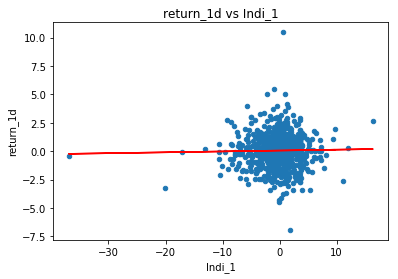

In [13]:
experiment_result('return_1d','Indi_1',price_indicator)

Correlation is : 0.07513308902238032


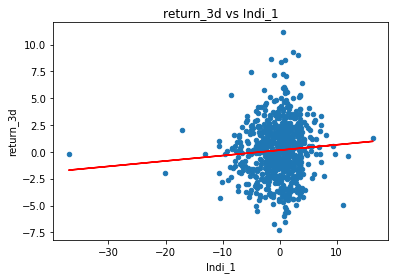

In [14]:
experiment_result('return_3d','Indi_1',price_indicator)

Correlation is : 0.04470662579357405


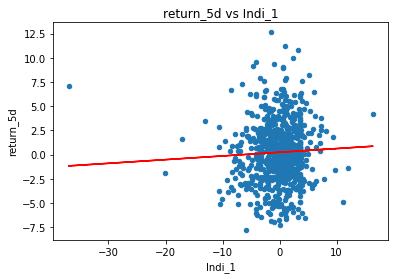

In [15]:
experiment_result('return_5d','Indi_1',price_indicator)

Correlation is : 0.05783792462648145


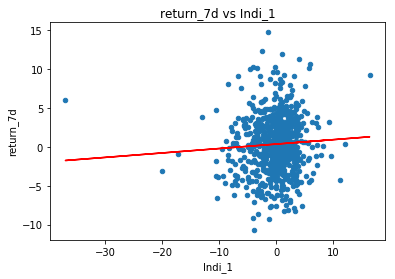

In [16]:
experiment_result('return_7d','Indi_1',price_indicator)

Correlation is : 0.08306855076550947


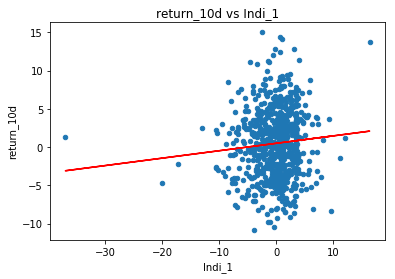

In [17]:
experiment_result('return_10d','Indi_1',price_indicator)

Correlation is : 0.013474432010069962


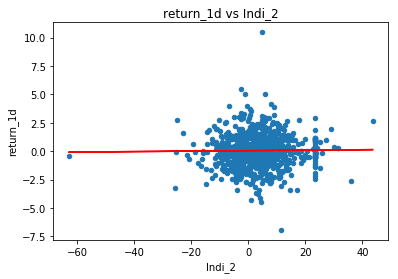

In [18]:
experiment_result('return_1d','Indi_2',price_indicator)

Correlation is : 0.08633867112934185


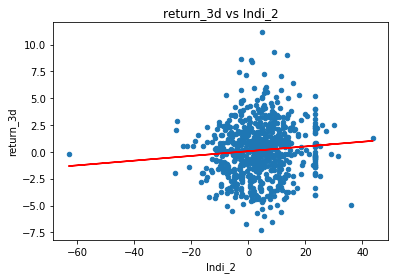

In [19]:
experiment_result('return_3d','Indi_2',price_indicator)

Correlation is : 0.06886208658091743


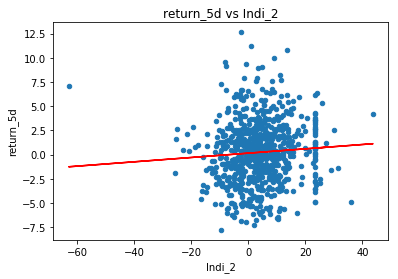

In [20]:
experiment_result('return_5d','Indi_2',price_indicator)

Correlation is : 0.07290147021801328


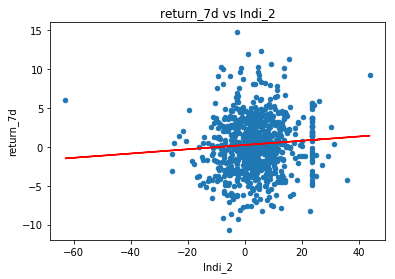

In [21]:
experiment_result('return_7d','Indi_2',price_indicator)

Correlation is : 0.11629083732332642


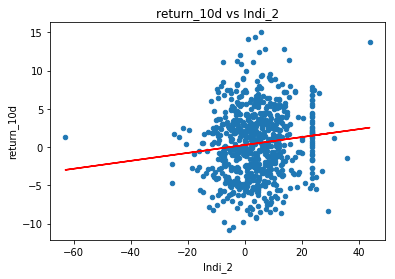

In [22]:
experiment_result('return_10d','Indi_2',price_indicator)

## Conclusion  1
From the experiment above, we are safe to assume that the sentiment score has incorporated the impact of past events in it instead of just being a random numerical value. Therefore, it makes sense for us to continue to improve the sentiment score as well as use it to do prediction for return

# Experiment relationship between forward return ratio and indicator 

In [23]:
price_forward = price.copy()

In [24]:
price_forward['return_1d'] = price_forward['return_1d'].shift(-1)
price_forward['return_3d'] = price_forward['return_3d'].shift(-3)
price_forward['return_5d'] = price_forward['return_5d'].shift(-5)
price_forward['return_7d'] = price_forward['return_7d'].shift(-7)
price_forward['return_10d'] = price_forward['return_10d'].shift(-10)


In [25]:
price_indicator_forward = indicator1.merge(price_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Date',axis=1,inplace = True)
price_indicator_forward = indicator2.merge(price_indicator_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Index',axis=1,inplace = True)
price_indicator_forward.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)
price_indicator_forward = price_indicator_forward.reindex(index=price_indicator_forward.index[::-1]).reset_index(drop = True)
price_indicator_forward = price_indicator_forward.dropna()

Correlation is : 0.06525999854841572


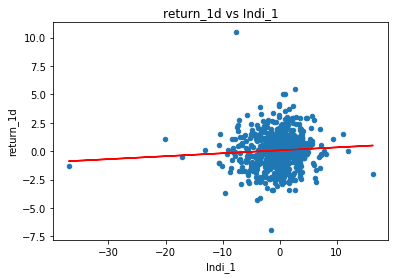

In [26]:
experiment_result('return_1d','Indi_1',price_indicator_forward)

Correlation is : 0.031235011521339586


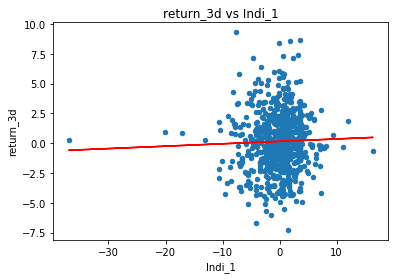

In [27]:
experiment_result('return_3d','Indi_1',price_indicator_forward)

Correlation is : 0.030558907793897017


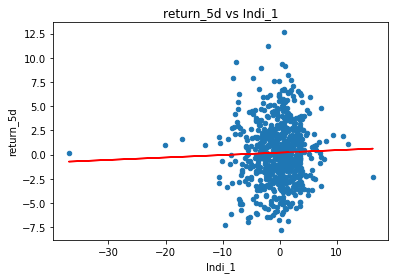

In [28]:
experiment_result('return_5d','Indi_1',price_indicator_forward)

Correlation is : 0.06525996883811636


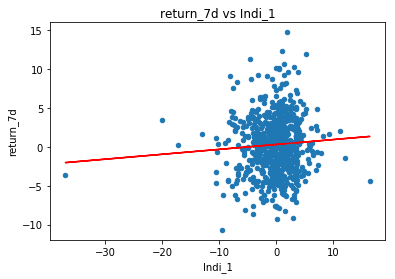

In [29]:
experiment_result('return_7d','Indi_1',price_indicator_forward)

Correlation is : 0.08144753307082703


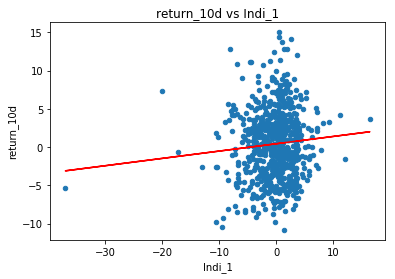

In [30]:
experiment_result('return_10d','Indi_1',price_indicator_forward)

Correlation is : 0.0642247203939994


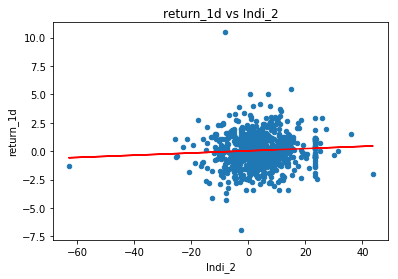

In [31]:
experiment_result('return_1d','Indi_2',price_indicator_forward)

Correlation is : 0.024241216559659315


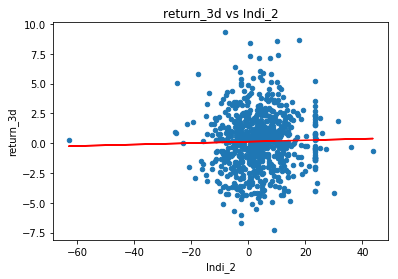

In [32]:
experiment_result('return_3d','Indi_2',price_indicator_forward)

Correlation is : 0.03711209172921273


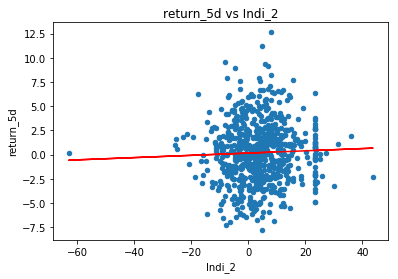

In [33]:
experiment_result('return_5d','Indi_2',price_indicator_forward)

Correlation is : 0.07508775747056808


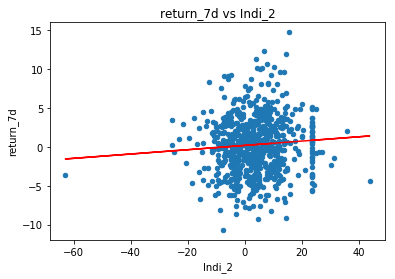

In [34]:
experiment_result('return_7d','Indi_2',price_indicator_forward)

Correlation is : 0.09219714219281379


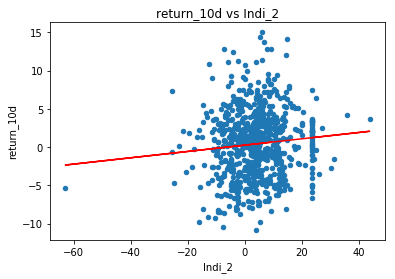

In [35]:
experiment_result('return_10d','Indi_2',price_indicator_forward)

## Conclusion  2
From the experiment above, we can tell sentiment score has zero correlation with future return. However, we can't conclude that it has zero predictive value in it. We will do other testing in next section 

# Experiment relationship between Volatility and indicator 

In [36]:
vol = price[[u'Index', u'LMZSDY', u'return_1d']].copy()

In [37]:
vol['Std'] = np.log(vol[u'return_1d'].rolling(10).std())

In [38]:
vol['std_1d'] = vol['Std'].shift(-1)
vol['std_3d'] = vol['Std'].shift(-3)
vol['std_5d'] = vol['Std'].shift(-5)
vol['std_7d'] = vol['Std'].shift(-7)
vol['std_10d'] = vol['Std'].shift(-10)

In [39]:
vol = vol.dropna()

In [40]:
vol_indicator = indicator1.merge(vol, left_on='Date', right_on='Index',how='inner')
vol_indicator.drop('Date',axis=1,inplace = True)
vol_indicator = indicator2.merge(vol_indicator, left_on='Date', right_on='Index',how='inner')
vol_indicator.drop('Index',axis=1,inplace = True)
vol_indicator.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)

Correlation is : -0.06082804165448442


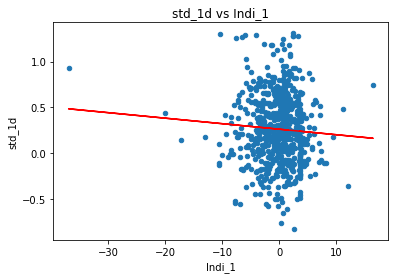

In [41]:
experiment_result('std_1d','Indi_1',vol_indicator)

Correlation is : -0.06972403130284635


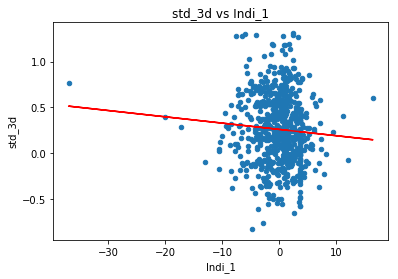

In [42]:
experiment_result('std_3d','Indi_1',vol_indicator)

Correlation is : -0.08420208705141521


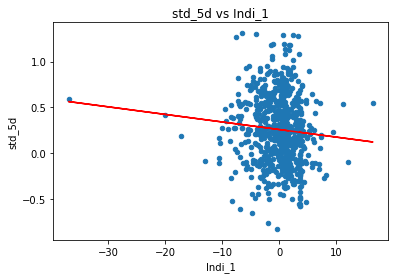

In [43]:
experiment_result('std_5d','Indi_1',vol_indicator)

Correlation is : -0.08332395532124581


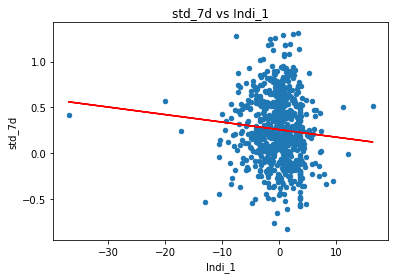

In [44]:
experiment_result('std_7d','Indi_1',vol_indicator)

Correlation is : -0.09468362196897233


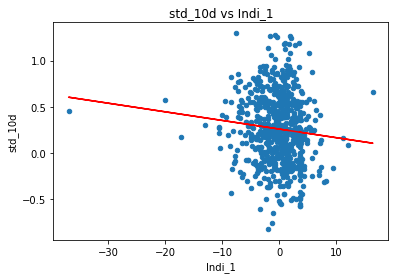

In [45]:
experiment_result('std_10d','Indi_1',vol_indicator)

Correlation is : -0.052298294986300835


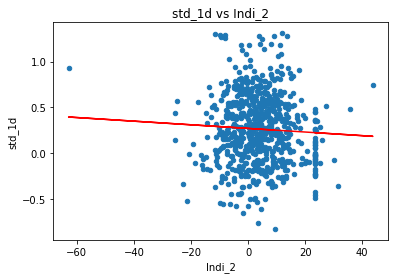

In [46]:
experiment_result('std_1d','Indi_2',vol_indicator)

Correlation is : -0.07828608664941025


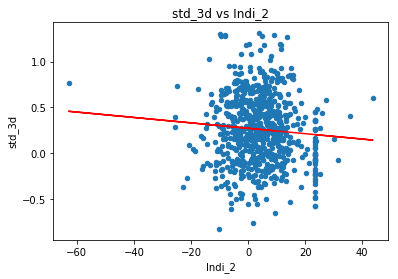

In [47]:
experiment_result('std_3d','Indi_2',vol_indicator)

Correlation is : -0.10517470061300713


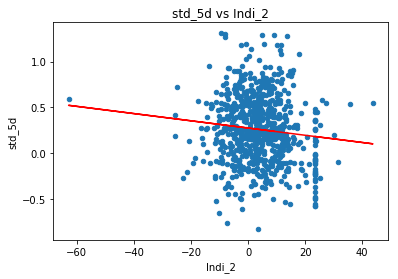

In [48]:
experiment_result('std_5d','Indi_2',vol_indicator)

Correlation is : -0.11268508026719583


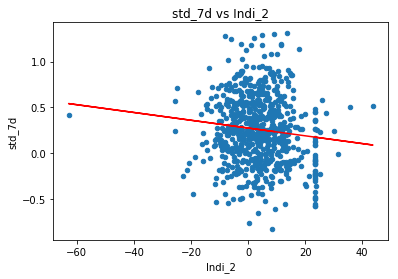

In [49]:
experiment_result('std_7d','Indi_2',vol_indicator)

Correlation is : -0.1166185450691886


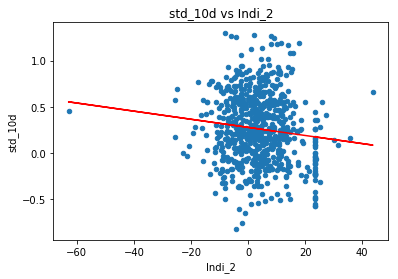

In [50]:
experiment_result('std_10d','Indi_2',vol_indicator)

## Conclusion  3
From the experiment above, we can tell sentiment score has certain negative correlation with future volatility. Therefore, it makes sense for us to continue to improve the sentiment score as well as use it to do prediction for volatility.


# Simple price prediction using indicator

In the following section, we will use the indicator to do simple prediction for different time horizon. The logis is as following:

1. If the indicator sign is bigger or equal to zero, we predict positive return for each time horizon
2. Else, negaive for each time horizon

Define a function to give positive sign to data point bigger than zero and negative sign to data point smaller than zero

In [51]:
def give_sign (data):
    if data>=0:
        return 1
    else:
        return -1

In [52]:
def prediction(result,data):
    indi_1 = data['Indi_1'].copy()
    indi_2 = data['Indi_2'].copy()
    sign_indi1 = indi_1.apply(give_sign)
    sign_indi2 = indi_2.apply(give_sign)
    
    sign_return = data[result].apply(give_sign)
    same_result_1= sign_return*sign_indi1
    reverse_result_1 = -sign_indi1*sign_return
    
    same_result_2= sign_return*sign_indi2
    reverse_result_2 = -sign_indi2*sign_return
    
    print('Number of positive in '+ result+ " : "+str(round(sign_return.value_counts()[1]/float(len(sign_return)),6)))
    print('Number of negative in '+ result+ " : "+str(round(sign_return.value_counts()[-1]/float(len(sign_return)),6)))
    print('Accuracy for following the same sign of Indicator 1 ' + result+ " : "+str(round(same_result_1.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 1 '+ result+ " : "+str(round(reverse_result_1.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the same sign of Indicator 2 ' + result+ " : "+str(round(same_result_2.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 2 '+ result+ " : "+str(round(reverse_result_2.value_counts()[1]/float(len(sign_return)),6)))

In [53]:
prediction('return_1d',price_indicator_forward)

Number of positive in return_1d : 0.52028
Number of negative in return_1d : 0.47972
Accuracy for following the same sign of Indicator 1 return_1d : 0.541259
Accuracy for following the reverse sign of Indicator 1 return_1d : 0.458741
Accuracy for following the same sign of Indicator 2 return_1d : 0.532867
Accuracy for following the reverse sign of Indicator 2 return_1d : 0.467133


In [54]:
prediction('return_3d',price_indicator_forward)

Number of positive in return_3d : 0.525874
Number of negative in return_3d : 0.474126
Accuracy for following the same sign of Indicator 1 return_3d : 0.51049
Accuracy for following the reverse sign of Indicator 1 return_3d : 0.48951
Accuracy for following the same sign of Indicator 2 return_3d : 0.499301
Accuracy for following the reverse sign of Indicator 2 return_3d : 0.500699


In [55]:
prediction('return_5d',price_indicator_forward)

Number of positive in return_5d : 0.53007
Number of negative in return_5d : 0.46993
Accuracy for following the same sign of Indicator 1 return_5d : 0.523077
Accuracy for following the reverse sign of Indicator 1 return_5d : 0.476923
Accuracy for following the same sign of Indicator 2 return_5d : 0.517483
Accuracy for following the reverse sign of Indicator 2 return_5d : 0.482517


In [56]:
prediction('return_7d',price_indicator_forward)

Number of positive in return_7d : 0.531469
Number of negative in return_7d : 0.468531
Accuracy for following the same sign of Indicator 1 return_7d : 0.527273
Accuracy for following the reverse sign of Indicator 1 return_7d : 0.472727
Accuracy for following the same sign of Indicator 2 return_7d : 0.527273
Accuracy for following the reverse sign of Indicator 2 return_7d : 0.472727


In [57]:
prediction('return_10d',price_indicator_forward)

Number of positive in return_10d : 0.53986
Number of negative in return_10d : 0.46014
Accuracy for following the same sign of Indicator 1 return_10d : 0.518881
Accuracy for following the reverse sign of Indicator 1 return_10d : 0.481119
Accuracy for following the same sign of Indicator 2 return_10d : 0.524476
Accuracy for following the reverse sign of Indicator 2 return_10d : 0.475524


## Conclusion  4
From the experiment above, we can observe that there is certain predictive value in this sentiment score. However, instead of following our initial strategy, we should go for different direction of the sentiment score. Further investigation will be required for us to run more complex model in order to improve the prediction